In [1]:
from matplotlib import use 
use('agg')
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cftime

from scipy.interpolate import interp1d
%matplotlib inline

In [2]:
e3sm_path = '/lcrc/group/earthscience/rjackson/e3sm_nsa/data/e3sm_data/v2_CTL.ne30pg2_15yrs.*'
ps_ds_path = '/lcrc/group/earthscience/rjackson/e3sm_nsa/data/e3sm_data/PS*.nc'
nsa_data_path = '/lcrc/group/earthscience/rjackson/e3sm_nsa/notebooks/e3sm_kmeans1.nc'

In [52]:
 e3sm_kmeans["time"].values[0].timestamp()

AttributeError: 'cftime._cftime.DatetimeNoLeap' object has no attribute 'timestamp'

In [45]:
e3sm_kmeans =xr.open_mfdataset(
        '/lcrc/project/land_atmos_modeling/caghili/NSA/NSA_kmeans_T_RH_anomaly_UV10_SP_WIND_labels.nc'
    ).compute()
    
#e3sm_kmeans['time'] = e3sm_kmeans['time'].to_datetimeindex()

nsa_cluster = e3sm_kmeans

bool_class1 = (e3sm_kmeans['label'] ==2)
bool_class2 = (e3sm_kmeans['label'] ==0)
bool_class3 = (e3sm_kmeans['label'] ==3)
bool_class4 = (e3sm_kmeans['label'] ==1)
nsa_cluster['cluster'] = xr.where(bool_class1, 0, 0)
nsa_cluster['cluster'] = xr.where(bool_class2, 1, e3sm_kmeans['cluster'])
nsa_cluster['cluster'] = xr.where(bool_class3, 2, e3sm_kmeans['cluster'])
nsa_cluster['cluster'] = xr.where(bool_class4, 3, e3sm_kmeans['cluster'])

In [3]:
# Load data
#nsa_cluster = xr.open_dataset(nsa_data_path)
e3sm_avgs = xr.open_mfdataset(e3sm_path + '*.nc')
ps_ds = xr.open_mfdataset(ps_ds_path)
Rd = 287.057
g0 = 9.80665
e3sm_avgs["P"] = e3sm_avgs["hyam"] * e3sm_avgs["P0"] + e3sm_avgs["hybm"] * ps_ds["PS"]
e3sm_avgs["heights"] = Rd * e3sm_avgs["T"] * (-np.log(e3sm_avgs["P"]) + np.log(ps_ds["PS"])) / g0 * 1e-3
print(e3sm_avgs)
rho = e3sm_avgs["P"] / (Rd * e3sm_avgs["T"])
content_conversion_factor = rho * 1e3

In [53]:
# Reindex cluster data to e3sm statistics
tolerance = np.timedelta64(1, 'D') / np.timedelta64(1, 'ns')
nsa_cluster = nsa_cluster.reindex(time=e3sm_avgs.time)

In [55]:
e3sm_avgs["cluster"] = nsa_cluster["cluster"]
heights = np.arange(0, 10., 0.01)

In [57]:
e3sm_avgs["cluster"].values

array([3, 1, 1, ..., 0, 0, 0])

In [58]:
e3sm_avgs["CLOUD_FILTER"] = e3sm_avgs["CLOUD"].where(e3sm_avgs["CLOUD"] > 0.01)
LWC_array = e3sm_avgs["CLDLIQ"].values / e3sm_avgs["CLOUD_FILTER"].values * content_conversion_factor
IWC_array = e3sm_avgs["CLDICE"].values / e3sm_avgs["CLOUD_FILTER"].values * content_conversion_factor
LWC_array += e3sm_avgs["RAINQM"].values * content_conversion_factor
IWC_array += e3sm_avgs["SNOWQM"].values * content_conversion_factor
LWC_array = np.where(np.isfinite(LWC_array), LWC_array, 0)
IWC_array = np.where(np.isfinite(IWC_array), IWC_array, 0)

In [ ]:
clear_pct = 1 - e3sm_avgs["CLOUD"].values
height = e3sm_avgs["heights"].values

LWC_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
IWC_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
clear_array_interp = np.zeros((LWC_array.shape[0], len(heights)))
for i in range(LWC_array.shape[0]):
    if i % 100 == 0:
        print('%d/%d' % (i, LWC_array.shape[0]))
    LWC = interp1d(height[i, :], LWC_array[i, :], fill_value="extrapolate")
    IWC = interp1d(height[i, :], IWC_array[i, :], fill_value="extrapolate")
    clear = interp1d(height[i, :], clear_pct[i, :], fill_value="extrapolate")
    LWC_array_interp[i, :] = LWC(heights)
    IWC_array_interp[i, :] = IWC(heights)
    clear_array_interp[i, :] = clear(heights)

0/3981
100/3981
200/3981
300/3981
400/3981
500/3981
600/3981
700/3981
800/3981
900/3981
1000/3981
1100/3981
1200/3981
1300/3981
1400/3981
1500/3981
1600/3981
1700/3981
1800/3981
1900/3981
2000/3981
2100/3981
2200/3981
2300/3981
2400/3981
2500/3981
2600/3981
2700/3981
2800/3981
2900/3981
3000/3981
3100/3981
3200/3981
3300/3981
3400/3981
3500/3981
3600/3981
3700/3981
3800/3981
3900/3981


In [17]:
e3sm_avgs["Avg_Retrieved_LWC_hybrid"] = xr.DataArray(
    data=LWC_array,
    dims=["time", "lev"],
    coords={"time": e3sm_avgs.time.values, "lev": e3sm_avgs.lev})

e3sm_avgs["Avg_Retrieved_IWC_hybrid"] = xr.DataArray(
    data=IWC_array,
    dims=["time", "lev"],
    coords={"time": e3sm_avgs.time.values, "lev": e3sm_avgs.lev})

e3sm_avgs["pct_clear_hybrid"] = xr.DataArray(data=clear_pct,
    dims=["time", "lev"],
    coords={"time": e3sm_avgs.time.values, "lev": e3sm_avgs.lev})

e3sm_avgs["Avg_Retrieved_LWC_hybrid"] = e3sm_avgs["Avg_Retrieved_LWC_hybrid"].where(
   e3sm_avgs["Avg_Retrieved_LWC_hybrid"] > 1e-4)
e3sm_avgs["Avg_Retrieved_IWC_hybrid"] = e3sm_avgs["Avg_Retrieved_IWC_hybrid"].where(
   e3sm_avgs["Avg_Retrieved_IWC_hybrid"] > 1e-4)
e3sm_avgs["mpc_occurrence_hybrid"] = xr.where(np.logical_and(
   e3sm_avgs["Avg_Retrieved_IWC_hybrid"] > 1e-4, e3sm_avgs["Avg_Retrieved_LWC_hybrid"] > 1e-4), 1 - e3sm_avgs["pct_clear_hybrid"], 0)
                                        
e3sm_avgs["Avg_Retrieved_LWC_height"] = xr.DataArray(
    data=LWC_array_interp,
    dims=["time", "height"],
    coords={"time": e3sm_avgs.time.values, "height": heights})

e3sm_avgs["Avg_Retrieved_IWC_height"] = xr.DataArray(
    data=IWC_array_interp,
    dims=["time", "height"],
    coords={"time": e3sm_avgs.time.values, "height": heights})

e3sm_avgs["pct_clear_height"] = xr.DataArray(data=clear_array_interp,
    dims=["time", "height"],
    coords={"time": e3sm_avgs.time.values, "height": heights})

e3sm_avgs["Avg_Retrieved_LWC_height"] = e3sm_avgs["Avg_Retrieved_LWC_height"].where(
   e3sm_avgs["Avg_Retrieved_LWC_height"] > 1e-4)
e3sm_avgs["Avg_Retrieved_IWC_height"] = e3sm_avgs["Avg_Retrieved_IWC_height"].where(
   e3sm_avgs["Avg_Retrieved_IWC_height"] > 1e-4)
e3sm_avgs["mpc_occurrence_height"] = xr.where(np.logical_and(
   e3sm_avgs["Avg_Retrieved_IWC_height"] > 1e-4, e3sm_avgs["Avg_Retrieved_LWC_height"] > 1e-4), 1 - e3sm_avgs["pct_clear_height"], 0)
                                        
e3sm_avgs["pct_clear_height"] = xr.DataArray(data=clear_array_interp,
    dims=["time", "height"],
    coords={"time": e3sm_avgs.time.values, "height": heights}) 
e3sm_avgs["season"] = e3sm_avgs["time"].dt.season


In [19]:
fig, ax = plt.subplots(4, 4, figsize=(12, 10))
colors = ['b', 'g', 'k', 'r']
i = 0
def cluster_mean(x, cluster_no):
    return x.where(x.cluster == cluster_no).mean("time", skipna=True)

for cluster in [1, 2, 3, 4]:
    cmean = lambda x: cluster_mean(x, cluster)
    e3sm_groupby = e3sm_avgs.groupby("season").apply(cmean)
    e3sm_groupby = e3sm_groupby.set_coords(["season", "lev"])
    
    for i, season in enumerate(["DJF", "MAM", "JJA", "SON"]):
        e3sm_groupby['Avg_Retrieved_LWC_hybrid'].sel(season=season).T.plot(
            ax=ax[i, 0], y="lev", linewidth=2, label=str(cluster), color=colors[cluster - 1])

        ax[i, 0].set_xlabel('LWC [g $m^{-3}$]')
        ax[i, 0].set_ylabel('Hybrid height')
        ax[i ,0].set_title('')
        ax[i, 0].set_xlim([0, 0.1])
        ax[i, 0].set_ylim([0, 1000])
        ax[i, 0].invert_yaxis()
        ax[i, 0].set_title(season)
        ax[i, 0].legend()
    
        e3sm_groupby['Avg_Retrieved_IWC_hybrid'].sel(season=season).T.plot(
            ax=ax[i, 1], y="lev", linewidth=2, label=str(cluster), color=colors[cluster - 1])
        ax[i, 1].set_xlabel('IWC [g $m^{-3}$]')
        ax[i, 1].set_ylabel('Hybrid height')
        ax[i, 1].set_title('')
        ax[i, 1].set_ylim([0, 1000])
        ax[i, 1].invert_yaxis()
        ax[i, 1].set_xlim([0, 0.03])
        ax[i, 1].set_title(season)

        (1 - e3sm_groupby['pct_clear_hybrid']).sel(season=season).T.plot(
            ax=ax[i, 2], y="lev", linewidth=2, label=str(cluster), color=colors[cluster - 1])
        ax[i, 2].set_xlabel('Cloud fraction')
        ax[i, 2].set_ylabel('Hybrid height')
        ax[i, 2].set_title('')
        ax[i, 2].set_xlim([0, 1])
        ax[i, 2].set_ylim([0, 1000])
        ax[i, 2].invert_yaxis()
        ax[i, 2].set_title(season)
        
        e3sm_groupby['mpc_occurrence_hybrid'].sel(season=season).T.plot(
            ax=ax[i, 3], y="lev", linewidth=2, label=str(cluster), color=colors[cluster - 1])
        ax[i, 3].set_xlabel('MPC occurrence')
        ax[i, 3].set_ylabel('Hybrid height')
        ax[i, 3].set_title('')
        ax[i, 3].set_ylim([0, 1000])
        ax[i, 3].invert_yaxis()
        ax[i, 3].set_xlim([0, 1])
        ax[i, 3].set_title(season)
fig.tight_layout()
fig.savefig('mean_stats_lev.png', bbox_inches='tight')

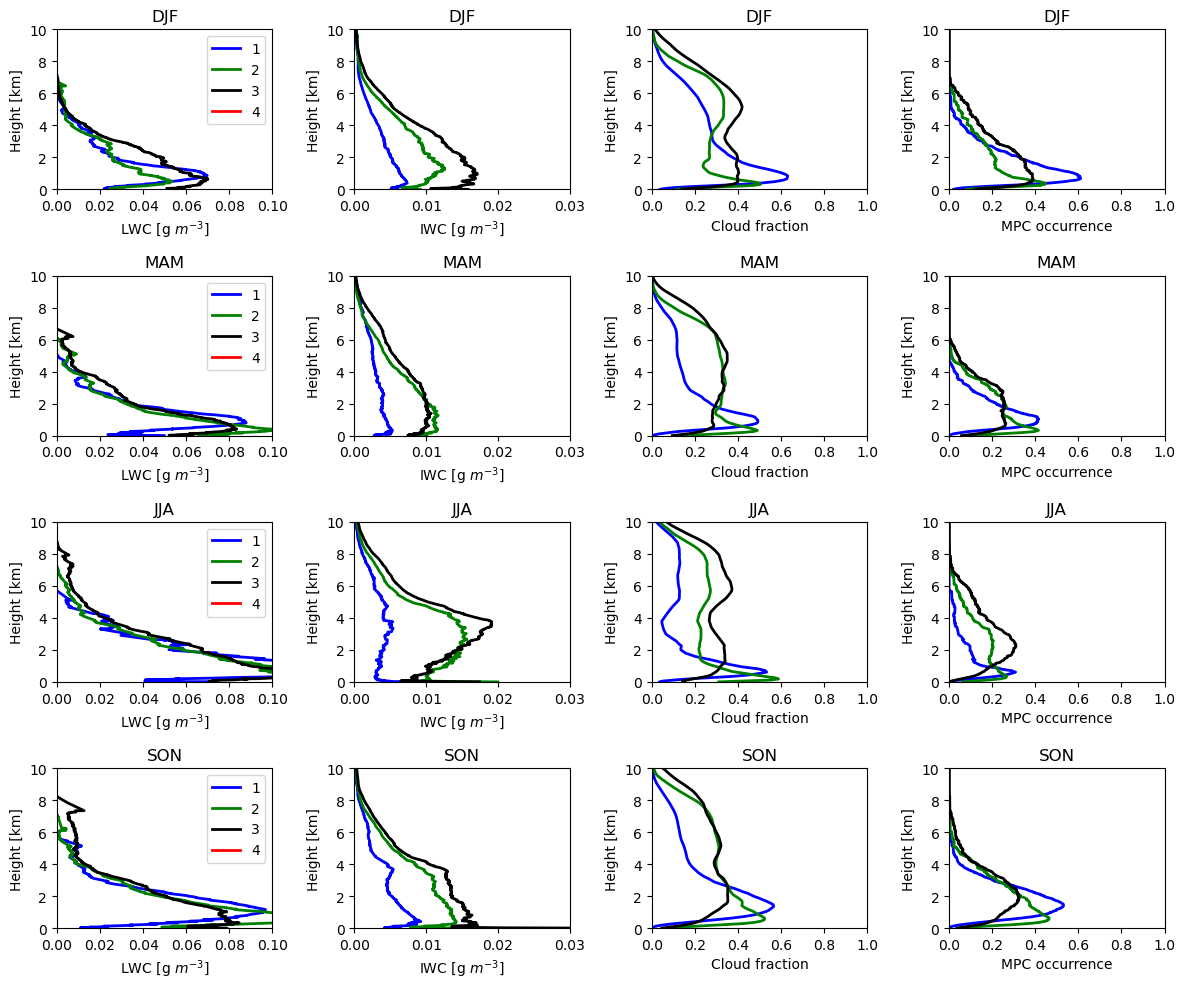

In [59]:
fig, ax = plt.subplots(4, 4, figsize=(12, 10))
colors = ['b', 'g', 'k', 'r']
i = 0
def cluster_mean(x, cluster_no):
    return x.where(x.cluster == cluster_no).mean("time", skipna=True)

for cluster in [1, 2, 3, 4]:
    cmean = lambda x: cluster_mean(x, cluster)
    e3sm_groupby = e3sm_avgs.groupby("season").apply(cmean)
    e3sm_groupby = e3sm_groupby.set_coords(["season", "height"])
    
    for i, season in enumerate(["DJF", "MAM", "JJA", "SON"]):
        e3sm_groupby['Avg_Retrieved_LWC_height'].sel(season=season).T.plot(
            ax=ax[i, 0], y="height", label=str(cluster), linewidth=2, color=colors[cluster - 1])

        ax[i, 0].set_xlabel('LWC [g $m^{-3}$]')
        ax[i, 0].set_ylabel('Height [km]')
        ax[i ,0].set_title('')
        ax[i, 0].set_xlim([0, 0.1])
        ax[i, 0].set_ylim([0, 10])
        ax[i, 0].set_title(season)
        ax[i, 0].legend()
    
        e3sm_groupby['Avg_Retrieved_IWC_height'].sel(season=season).T.plot(
            ax=ax[i, 1], y="height", label=str(cluster), linewidth=2, color=colors[cluster - 1])
        ax[i, 1].set_xlabel('IWC [g $m^{-3}$]')
        ax[i, 1].set_ylabel('Height [km]')
        ax[i, 1].set_title('')
        ax[i, 1].set_ylim([0, 10])
        ax[i, 1].set_xlim([0, 0.03])
        ax[i, 1].set_title(season)

        (1 - e3sm_groupby['pct_clear_height']).sel(season=season).T.plot(
            ax=ax[i, 2], y="height", label=str(cluster), linewidth=2, color=colors[cluster - 1])
        ax[i, 2].set_xlabel('Cloud fraction')
        ax[i, 2].set_ylabel('Height [km]')
        ax[i, 2].set_title('')
        ax[i, 2].set_xlim([0, 1])
        ax[i, 2].set_ylim([0, 10])
        ax[i, 2].set_title(season)
        
        e3sm_groupby['mpc_occurrence_height'].sel(season=season).T.plot(
            ax=ax[i, 3], y="height", label=str(cluster), linewidth=2, color=colors[cluster - 1])
        ax[i, 3].set_xlabel('MPC occurrence')
        ax[i, 3].set_ylabel('Height [km]')
        ax[i, 3].set_title('')
        ax[i, 3].set_ylim([0, 10])
        ax[i, 3].set_xlim([0, 1])
        ax[i, 3].set_title(season)
fig.tight_layout()
fig.savefig('mean_stats_height_ln.png', bbox_inches='tight')

In [ ]:
e3sm_avgs